## **Classification with Generative Models**

### Encoder-decoder Models

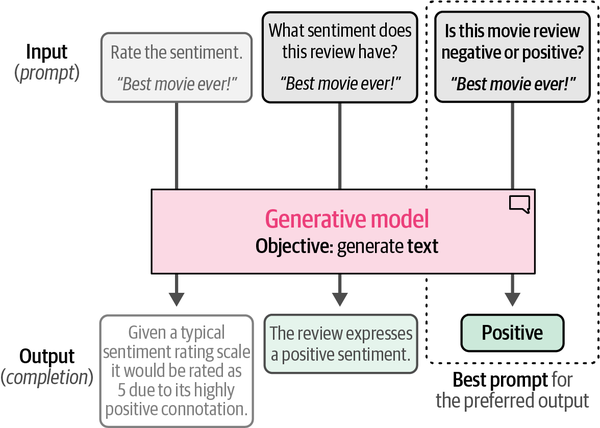

In [10]:
import argparse
import logging
from datasets import load_dataset
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm import tqdm
from sklearn.metrics import classification_report

# --------------------------
# Logging config
# --------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --------------------------
# Model Loading
# --------------------------
def load_model(model_name: str, device: str):
    logger.info(f"Loading model: {model_name} on {device}")
    return pipeline("text2text-generation", model=model_name, device=device)

# --------------------------
# Prepare Data
# --------------------------
def prepare_data(data, prompt: str):
    return data.map(lambda example: {"t5": prompt + example['text']})

# --------------------------
# Inference
# --------------------------
def run_inference(pipe, dataset, input_key="t5"):
    predictions = []
    for output in tqdm(pipe(KeyDataset(dataset, input_key)), total=len(dataset)):
        generated = output[0]["generated_text"].strip().lower()
        if generated not in ["positive", "negative"]:
            logger.warning(f"Unexpected output: {generated}")
            pred = -1  # or handle differently
        else:
            pred = 1 if generated == "positive" else 0
        predictions.append(pred)
    return predictions

# --------------------------
# Evaluation
# --------------------------
def evaluate(true_labels, predicted_labels):
    print(classification_report(true_labels, predicted_labels, digits=3))

# --------------------------
# Main
# --------------------------
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", default="google/flan-t5-small")
    parser.add_argument("--device", default="cuda:0")
    parser.add_argument("--prompt", default="Is the following sentence positive or negative? ")
    args, _ = parser.parse_known_args()

    data = load_dataset("imdb")
    data["test"] = data["test"].shuffle(seed=42).select(range(1000))  # limit for demo

    pipe = load_model(args.model, args.device)
    data = prepare_data(data, args.prompt)

    predictions = run_inference(pipe, data["test"])
    evaluate(data["test"]["label"], predictions)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

100%|██████████| 1000/1000 [01:04<00:00, 15.44it/s]


              precision    recall  f1-score   support

           0      0.905     0.893     0.899       512
           1      0.889     0.902     0.895       488

    accuracy                          0.897      1000
   macro avg      0.897     0.897     0.897      1000
weighted avg      0.897     0.897     0.897      1000



### Flan-T5 for Classification

In [13]:
from transformers import pipeline
from datasets import load_dataset
from sklearn.metrics import classification_report
from tqdm import tqdm
import torch

# ----------------------------
# Load model (Flan-T5)
# ----------------------------
device = 0 if torch.cuda.is_available() else -1
pipe = pipeline("text2text-generation", model="google/flan-t5-base", device=device)

# ----------------------------
# Prompt template
# ----------------------------
prompt_template = """Predict whether the following document is a positive or negative movie review:

[DOCUMENT]

If it is positive return 1 and if it is negative return 0. Do not give any other answers.
"""

# ----------------------------
# Load and shuffle dataset
# ----------------------------
data = load_dataset("imdb")
data["test"] = data["test"].shuffle(seed=42).select(range(200))  # reduce size for speed

# ----------------------------
# Run prediction
# ----------------------------
def generate_prediction(document):
    prompt = prompt_template.replace("[DOCUMENT]", document)
    output = pipe(prompt, max_new_tokens=10)[0]["generated_text"].strip().lower()

    # تلاش برای استخراج برچسب عددی
    if "negative" in output or output.startswith("0"):
        return "0"
    elif "positive" in output or output.startswith("1"):
        return "1"
    else:
        return -1  # نامشخص


# Generate predictions
predictions = []
for doc in tqdm(data["test"]["text"]):
    output = generate_prediction(doc)
    if output not in ["0", "1"]:
        predictions.append(-1)  # unknown / bad output
    else:
        predictions.append(int(output))

# ----------------------------
# Evaluation
# ----------------------------
true_labels = data["test"]["label"]
print(classification_report(true_labels, predictions, digits=3))


Device set to use cuda:0
100%|██████████| 200/200 [00:22<00:00,  9.03it/s]


              precision    recall  f1-score   support

           0      0.763     0.990     0.862       104
           1      0.985     0.667     0.795        96

    accuracy                          0.835       200
   macro avg      0.874     0.829     0.828       200
weighted avg      0.869     0.835     0.830       200

